## [Observability for LlamaIndex Workflows](https://langfuse.com/guides/cookbook/integration_llamaindex_workflows)

How to use Langfuse to gain real-time observability for your LlamaIndex Workflows.

**What are LlamaIndex Workflows?** LlamaIndex Workflows is a flexible, event-driven framework designed to build robust AI agents. In LlamaIndex, workflows are created by chaining together multiple steps—each defined and validated using the @step decorator. Every step processes specific event types, allowing you to orchestrate complex processes such as AI agent collaboration, RAG flows, data extraction, and more.

**What is Langfuse?** Langfuse is the open source LLM engineering platform. It helps teams to collaboratively manage prompts, trace applications, debug problems, and evaluate their LLM system in production.

### Step 1: Install Dependencies

In [1]:
%pip install langfuse openai llama-index-workflows llama-index-core llama-index-llms-openai openinference-instrumentation-llama_index llama-index-instrumentation

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


### Step2: Set Up Environment Variables

In [1]:
import os

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a"
os.environ["LANGFUSE_HOST"] = "http://localhost:3000"

# Your openai key
# os.environ["OPENAI_API_KEY"] = "f0c1fb9f5c534e55a66d9e539916fdb0.GQKa6HaX6MpT9ioJ"
os.environ["OPENAI_API_KEY"] = "73c80b33ad68446ea3f059efe5c1a65f.T2PZjYiHcT2JYx2a"
os.environ["OPENAI_BASE_URL"] = "https://open.bigmodel.cn/api/paas/v4"

In [2]:
from langfuse import get_client

langfuse = get_client()

# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


### Step 3: Initialize LlamaIndex Instrumentation

In [ ]:
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from llama_index.core import Settings
from langchain_openai.chat_models import ChatOpenAI
# from openai import OpenAI
# from langfuse.openai import OpenAI


# Initialize LlamaIndex instrumentation
LlamaIndexInstrumentor().instrument()

# 初始化 LLM
llm = ChatOpenAI(
    model_name="glm-4.5-flash",
)


# 设置为全局默认
Settings.llm = llm

Attempting to instrument while already instrumented


### Step 4: Create a Simple LlamaIndex Workflows Application

In LlamaIndex Workflows, you build event-driven AI agents by defining steps with the @step decorator. Each step processes an event and, if appropriate, emits new events. In this example, we create a simple workflow with two steps: one that pre-processes an incoming event and another that generates a reply

In [50]:
from llama_index.core.llms import ChatMessage
# from llama_index.llms.openai import OpenAI
from langfuse.openai import openai
from typing import Annotated

from workflows import Workflow, step
from workflows.events import StartEvent, StopEvent
from workflows.resource import Resource


def get_llm(**kwargs):
    # return OpenAI()
    return openai.OpenAI()
    
class MyWorkFlow(Workflow):
    @step
    async def step1(
        self, ev: StartEvent, llm: Annotated[OpenAI, Resource(get_llm)]
    ) -> StopEvent:
        # messages = ChatMessage(role="user", content=ev.get("input"))
        # response = await llm.chat([messages])
        # return StopEvent(result=response.message.content)

        messages = [{"role": "user", "content": ev.get("input")}]
        resp = llm.chat.completions.create(
            model="GLM-4.5-Flash",
            messages=messages,
        )

        content = None
        try:
            content = resp.choices[0].message.content
        except Exception:
            content = getattr(resp, "content", str(resp))

        return StopEvent(result=content)   
    
w = MyWorkFlow()

In [ ]:
response = await w.run(input="What is LlamaIndex?")
print(response)

**LlamaIndex** is a **data framework** designed to **connect Large Language Models (LLMs)** like GPT-4, Llama, or Claude with external data sources. It acts as a bridge between LLMs and your private data (documents, databases, APIs, etc.), enabling more accurate, context-aware responses by grounding the LLM in your specific information.

---

### **Key Problems LlamaIndex Solves**
1. **LLMs Lack Context**: LLMs have limited knowledge about your private documents, databases, or real-time data.  
2. **Data Silos**: Critical information is scattered across PDFs, SQL databases, Notion pages, APIs, etc.  
3. **Hallucinations**: LLMs may invent facts when not provided with relevant data.  
4. **Complex Workflows**: Integrating data sources with LLMs requires custom code for retrieval, transformation, and querying.

---

### **Core Features**
1. **Data Connectors**  
   - Pre-built tools to ingest data from 100+ sources:  
     - Files (PDF, Word, CSV, Markdown)  
     - Databases (PostgreSQL

### Step 5: View Traces in Langfuse

[Langfuse cloud trace](https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/e0987dce85c8c49602030599b84e77e8?timestamp=2025-07-01T09%3A42%3A54.701Z&display=details&observation=68e47e5c1709d0df)



[Langfuse local_host trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?peek=1d083cca885404fa6446cb0b97d792b6&timestamp=2025-09-11T09%3A54%3A30.064Z&observation=42307293010bb387)

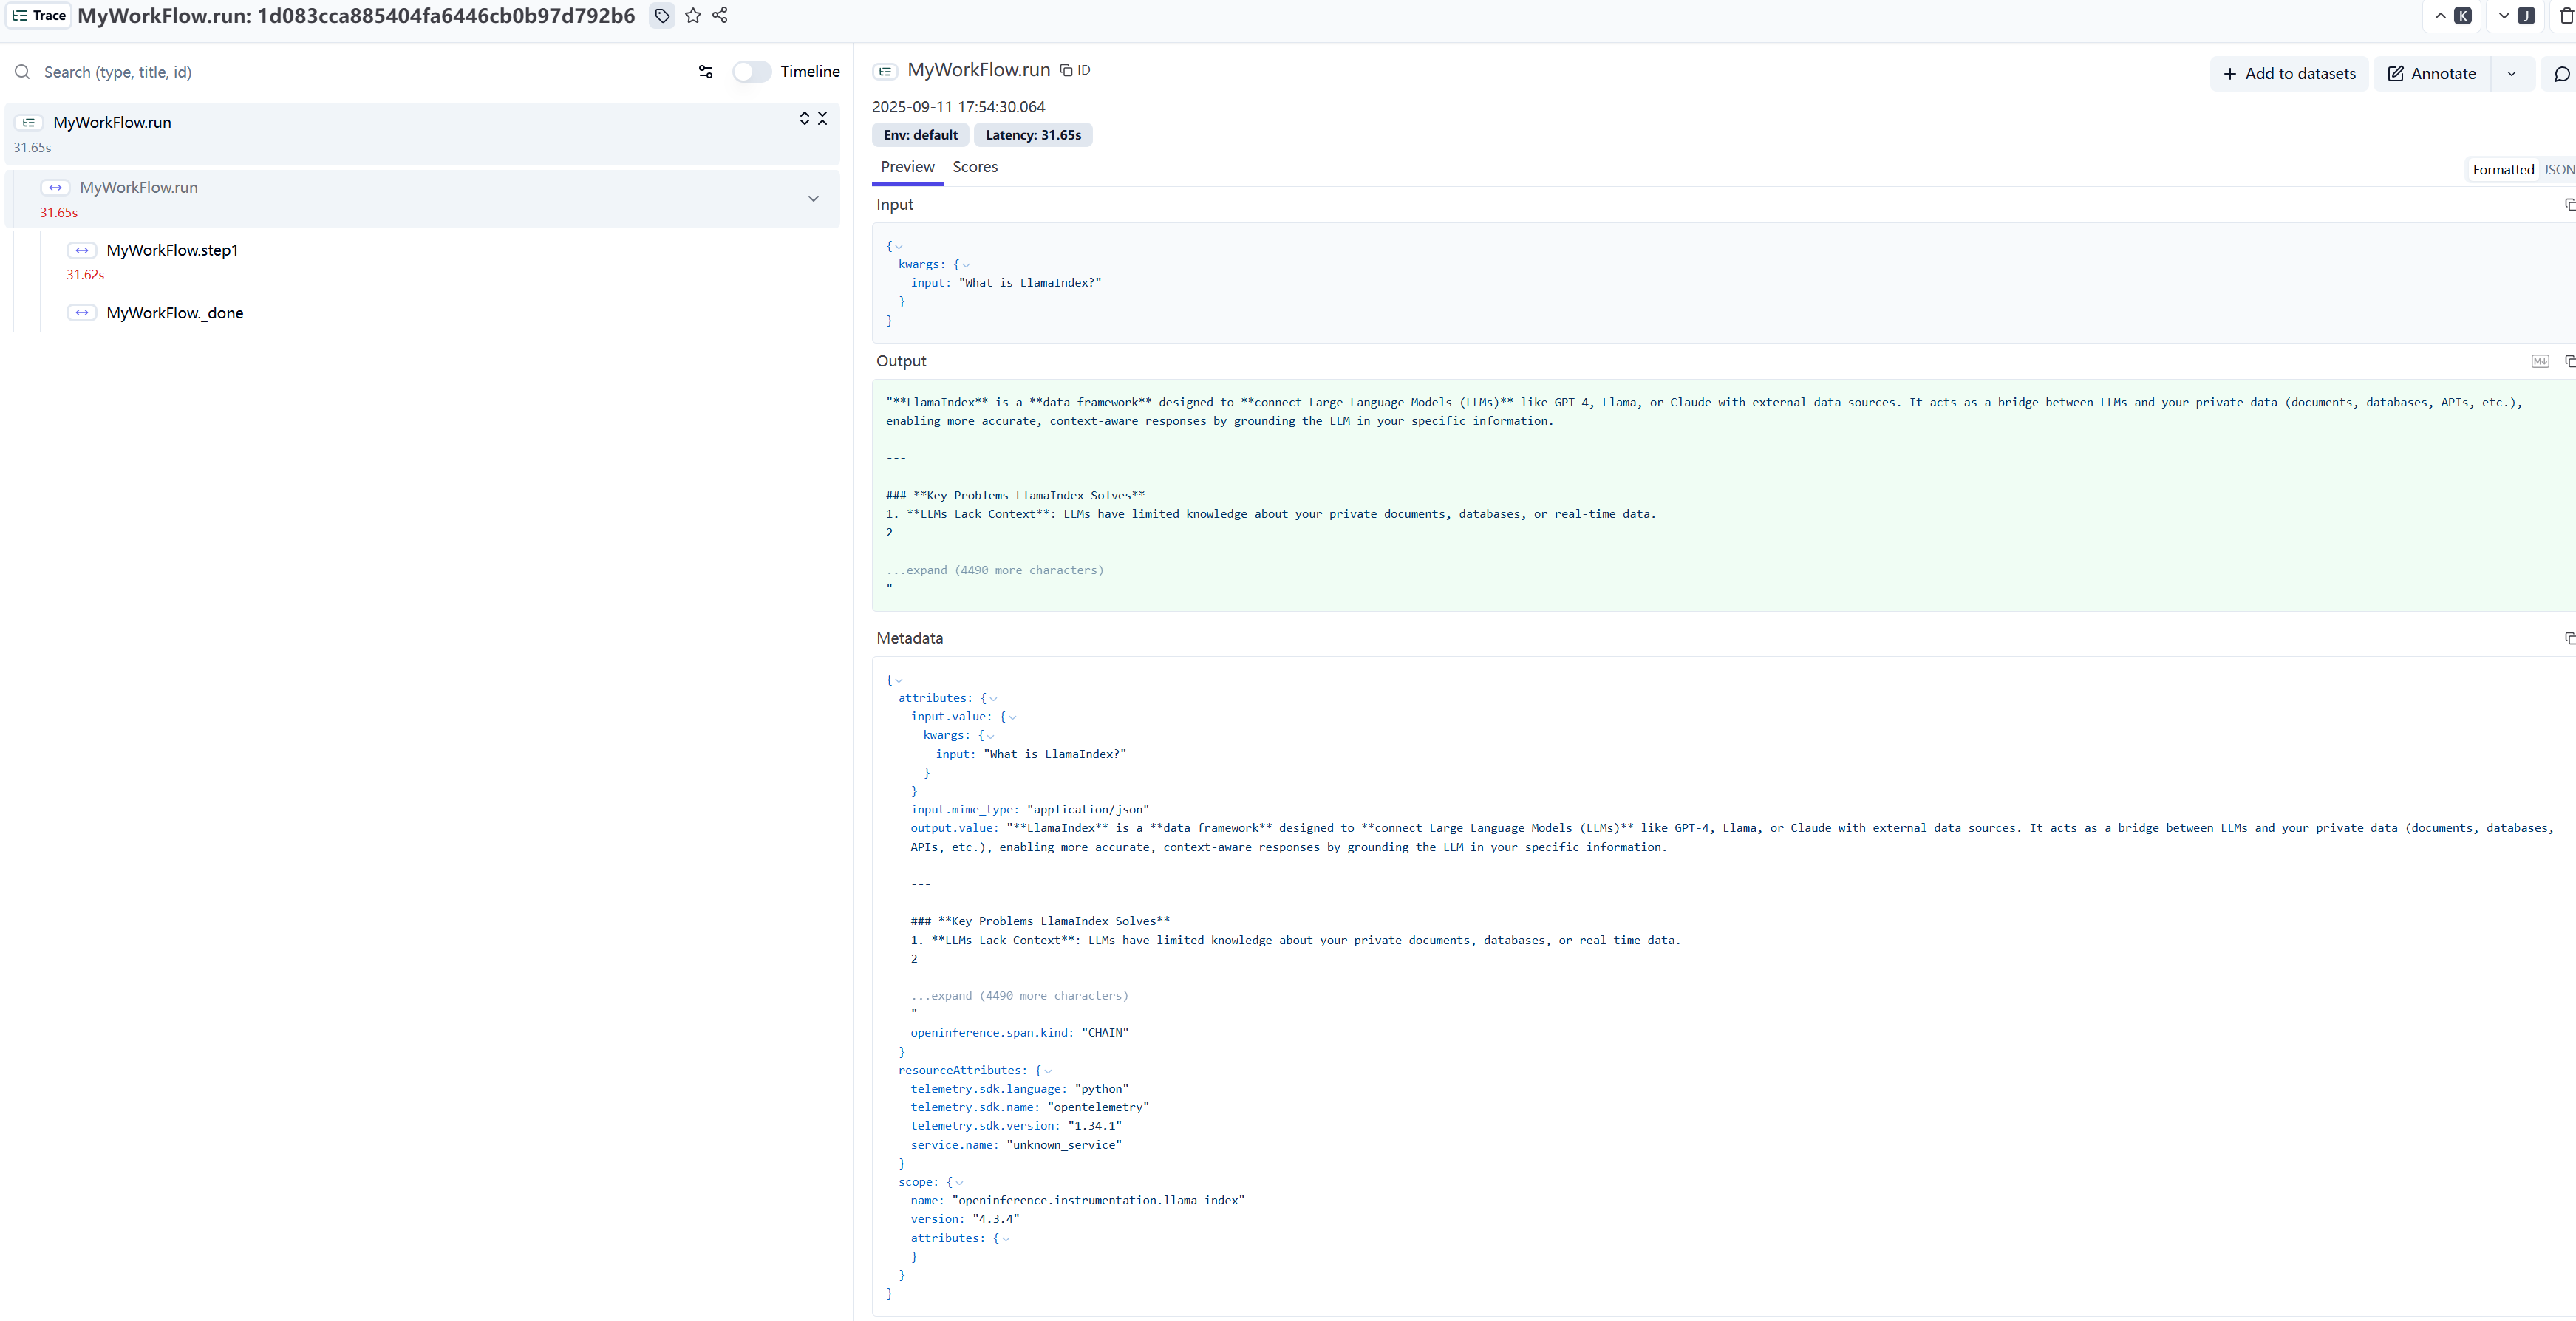

### Interoperability with the Python SDK

In [57]:
from langfuse import observe, get_client
 
langfuse = get_client()
 
@observe()
async def my_instrumented_function(input):
    output = await w.run(input=input)

    langfuse.update_current_trace(
        input=input,
        output=output,
        user_id="user_123",
        session_id="session_abc",
        tags=["agent", "my-llamaindex-trace"],
        metadata={"email": "user@langfuse.com"},
        version="1.0.0"
    )
    trace_id = langfuse.get_current_trace_id()
    print(f"Trace ID: {trace_id}")
    return trace_id

result = await my_instrumented_function("What is Langfuse?")

Trace ID: 4ecf7d2799f3400167a9f54719177b11


In [58]:
trace_id = "4ecf7d2799f3400167a9f54719177b11"

# Score the trace
langfuse.create_score(
    trace_id=trace_id,
    name="correct-answer",
    value=1.0,
    data_type="NUMERIC", 
    comment="The answer is identical to the sample solution, indicating it is correct.",
)

In [ ]:
# Summarize cost by model
import pandas as pd

trace = langfuse.api.trace.get("4ecf7d2799f3400167a9f54719177b11")
observations = trace.observations


def summarize_usage(observations):
    """Summarize usage data grouped by model."""
    usage_data = []

    for obs in observations:
        usage = obs.usage
        if usage:
            usage_data.append(
                {
                    "model": obs.model,
                    "input_tokens": usage.input,
                    "output_tokens": usage.output,
                    "total_tokens": usage.total,
                }
            )

    df = pd.DataFrame(usage_data)
    if df.empty:
        return pd.DataFrame()

    summary = df.groupby("model").sum()
    return summary


# Example usage (assuming `observations` is defined as in the provided code):
summary_df = summarize_usage(observations)
summary_df

,input_tokens,output_tokens,total_tokens
model,,,
GLM-4.5-Flash,10,1677,1687


: 

[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/4ecf7d2799f3400167a9f54719177b11?timestamp=2025-09-11T10:07:35.610Z&display=details)

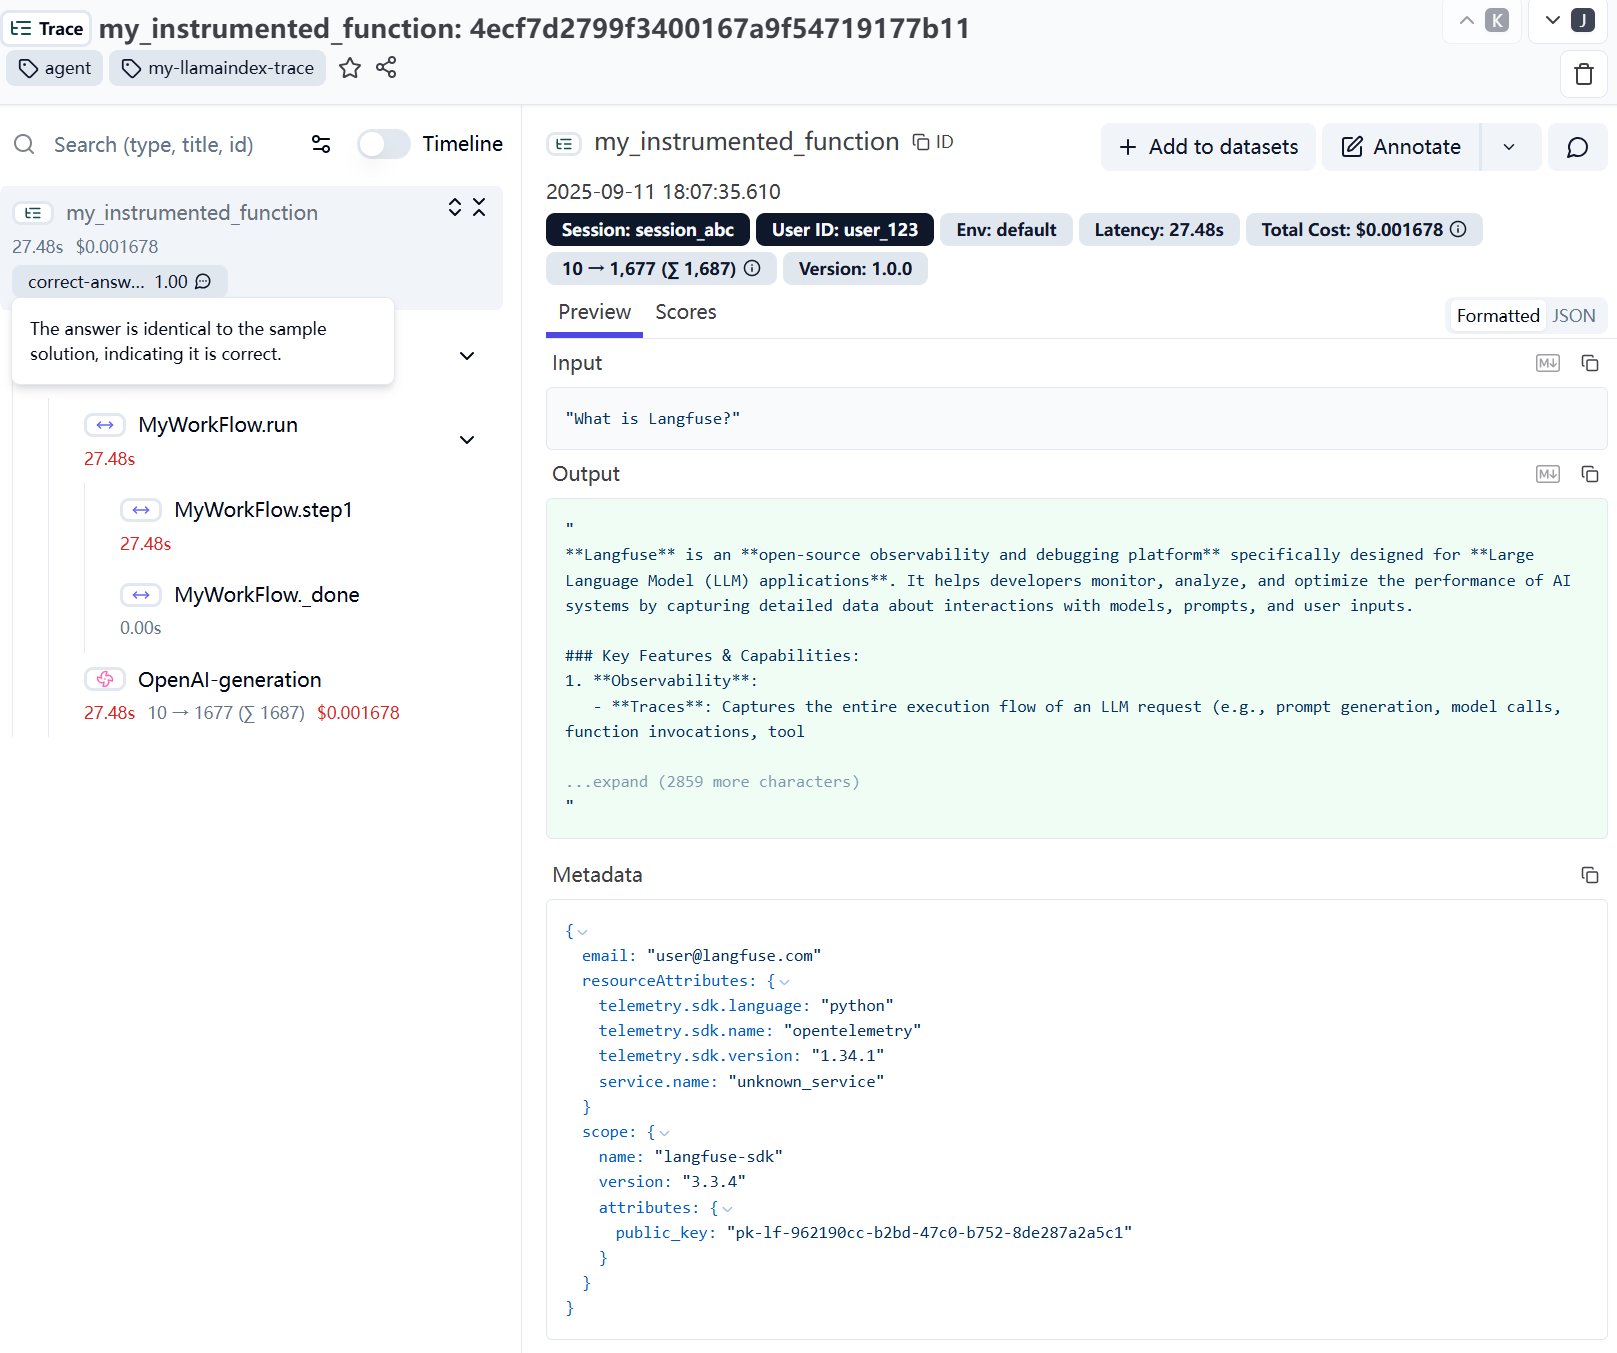